In [1]:
!pwd

/data/marciano/experiments/multi-organ-qc/src/notebooks


In [2]:
%cd /data/marciano/experiments/multi-organ-qc

/data/marciano/experiments/multi-organ-qc


In [3]:
!pwd

/data/marciano/experiments/multi-organ-qc


## Data preparation

In [4]:
import os
import numpy as np
from src.utils.utilsAcdc import generate_patient_info, preprocess

patient_info = generate_patient_info("data/heart/training/", patient_ids=range(1, 101))
patient_info = {**patient_info, **generate_patient_info("data/heart/testing/", patient_ids=range(101, 151))}

if not os.path.exists("preprocessed/heart"):
    os.makedirs("preprocessed/heart/")
np.save(os.path.join("preprocessed/heart/", "patient_info"), patient_info)

#spacings = [patient_info[id]["spacing"] for id in range(1, 101)]
#spacing_target = np.percentile(np.vstack(spacings), 50, 0)
spacing_target = [10, 1.25, 1.25]

if not os.path.exists("preprocessed/heart/training/"):
    os.makedirs("preprocessed/heart/training/")
preprocess(
    range(1,101), patient_info, spacing_target,
    "data/heart/training", "preprocessed/heart/training",
    lambda folder, id: os.path.join(folder, 'patient{:03d}'.format(id)),
    lambda patient_info, id, phase: "patient{:03d}_frame{:02d}_gt.nii.gz".format(id, patient_info[id][phase])
)

for model in os.listdir("data/heart/predictions/"):
    if not os.path.exists("preprocessed/heart/predictions/{}".format(model)):
        os.makedirs("preprocessed/heart/predictions/{}".format(model))
    preprocess(
        range(101,151), patient_info, spacing_target,
        "data/heart/predictions/{}".format(model), "preprocessed/heart/predictions/{}".format(model),
        lambda folder, id: folder,
        lambda patient_info, id, phase: "patient{:03d}_{}.nii.gz".format(id,phase)
    ) 

## Dataset

In [4]:
import os
import numpy as np
import random
import torchvision
from src.utils.utilsAcdc import AddPadding, CenterCrop, OneHot, ToTensor, MirrorTransform, SpatialTransform

ids = random.sample(range(1, 101), 100)
train_ids = ids[:80]
val_ids = ids[80:]

transform = torchvision.transforms.Compose([
    AddPadding((256,256)),
    CenterCrop((256,256)),
    OneHot(),
    ToTensor()
])
transform_augmentation = torchvision.transforms.Compose([
    MirrorTransform(),
    SpatialTransform(patch_size=(256,256), angle_x=(-np.pi/6,np.pi/6), scale=(0.7,1.4), random_crop=True),
    OneHot(),
    ToTensor()
])

## Training

In [5]:
import sys, importlib
#importlib.reload(sys.modules['src/ConvAE'])

import torch
from src.ConvAE.basic_model import AE
from src.ConvAE.utils import hyperparameter_tuning, plot_history
from src.utils.utilsAcdc import ACDCDataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#the following cell allows the user to tune his own hyperparameters. In case you wanna try our hyperparameters first, just skip this cell.

#this is a list of possible values being tested for each hyperparameter.
parameters = {
    "DA": [True, False], #data augmentation
    "latent_size": [100, 500], #size of the latent space of the autoencoder
    "BATCH_SIZE": [8, 16, 4],
    "optimizer": [torch.optim.Adam],
    "lr": [2e-4, 1e-4, 1e-3],
    "weight_decay": [1e-5],
    "tuning_epochs": [5, 10], #number of epochs each configuration is run for
    "functions": [["GDLoss", "MSELoss"], ["GDLoss"], ["BKGDLoss", "BKMSELoss"]], #list of loss functions to be evaluated. BK stands for "background", which is a predominant and not compulsory class (it can lead to a dumb local minimum retrieving totally black images).
    "settling_epochs_BKGDLoss": [10, 0], #during these epochs BK has half the weight of LV, RV and MYO in the evaluation of BKGDLoss
    "settling_epochs_BKMSELoss": [10, 0], #during these epochs BK has half the weight of LV, RV and MYO in the evaluation of BKMSELoss
}

#this is a list of rules cutting out some useless combinations of hyperparameters from the tuning process.
rules = [
    '"settling_epochs_BKGDLoss" == 0 or "BKGDLoss" in "functions"',
    '"settling_epochs_BKMSELoss" == 0 or "BKMSELoss" in "functions"',
    '"BKGDLoss" not in "functions" or "settling_epochs_BKGDLoss" <= "tuning_epochs"',
    '"BKMSELoss" not in "functions" or "settling_epochs_BKMSELoss" <= "tuning_epochs"',
    #'"BKGDLoss" not in "functions" or "settling_epochs_BKGDLoss" >= "settling_epochs_BKMSELoss"'
]

In [ ]:
optimal_parameters = hyperparameter_tuning(
    parameters,
    ACDCDataLoader("preprocessed/heart/training", patient_ids=train_ids, batch_size=None, transform=None),
    ACDCDataLoader("preprocessed/heart/training", patient_ids=val_ids, batch_size=None, transform=None),
    transform, transform_augmentation,
    rules,
    fast=True) #very important parameter. When False, all combinations are tested to return the one retrieving the maximum DSC. When True, the first combination avoiding dumb local minima is returned.

np.save(os.path.join("preprocessed/heart/", "optimal_parameters"), optimal_parameters)

AE(
  (encoder): Sequential(
    (0): Conv2d(4, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Dropout(p=0.5, inplace=False)
    (8): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Dropout(p=0.5, inplace=False)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.2)
    (15): Dropout(p=0.5, inplace=False

Epochs progress:   0%|          | 0/50 [00:00<?, ?it/s]

data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
data shape : (16, 304, 257)
slice_id = 0
data shape : (16, 304, 257)
slice_id = 1
data shape : (16, 304, 257)
slice_id = 2
data shape : (16, 304, 257)
slice_id = 3
data s

Epochs progress:   2%|▏         | 1/50 [00:14<11:58, 14.66s/it]

Epoch [0]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
1.0837	0.0202	1.1039	0.9777	12.700	0.0000	nan	0.0000	nan	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
data shap

Epochs progress:   4%|▍         | 2/50 [00:28<11:23, 14.23s/it]

Epoch [1]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
1.0508	0.0198	1.0706	0.9777	12.700	0.0000	nan	0.0000	nan	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
data shap

Epochs progress:   6%|▌         | 3/50 [00:48<13:16, 16.95s/it]

Epoch [2]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.8646	0.0129	0.8774	0.9877	11.087	0.0192	33.866	0.3074	11.692	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
dat

Epochs progress:   8%|▊         | 4/50 [01:09<14:05, 18.38s/it]

Epoch [3]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.7508	0.0120	0.7628	0.9900	10.642	0.1131	31.449	0.2489	10.225	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
dat

Epochs progress:  10%|█         | 5/50 [01:29<14:17, 19.06s/it]

Epoch [4]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.6929	0.0123	0.7052	0.9909	10.361	0.3046	26.297	0.0337	15.859	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
dat

Epochs progress:  12%|█▏        | 6/50 [01:49<14:14, 19.41s/it]

Epoch [5]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.6173	0.0119	0.6292	0.9908	10.331	0.4909	20.906	0.0106	25.831	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
dat

Epochs progress:  14%|█▍        | 7/50 [02:09<14:06, 19.69s/it]

Epoch [6]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.6054	0.0120	0.6175	0.9902	10.460	0.5502	19.932	0.0073	32.349	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
dat

Epochs progress:  16%|█▌        | 8/50 [02:30<13:52, 19.82s/it]

Epoch [7]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.6024	0.0116	0.6140	0.9905	10.328	0.5300	19.435	0.0096	33.862	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
dat

Epochs progress:  18%|█▊        | 9/50 [02:50<13:37, 19.93s/it]

Epoch [8]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.5992	0.0121	0.6113	0.9899	10.532	0.5488	19.831	0.0148	33.545	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
dat

Epochs progress:  20%|██        | 10/50 [03:10<13:19, 19.99s/it]

Epoch [9]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.5895	0.0121	0.6015	0.9900	10.288	0.5839	17.812	0.0262	33.089	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
dat

Epochs progress:  22%|██▏       | 11/50 [03:30<13:02, 20.07s/it]

Epoch [10]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0251	0.0117	0.0368	0.9902	10.228	0.5745	18.341	0.0264	31.459	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  24%|██▍       | 12/50 [03:50<12:44, 20.11s/it]

Epoch [11]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0251	0.0117	0.0367	0.9901	10.232	0.5603	18.701	0.0263	30.715	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  26%|██▌       | 13/50 [04:11<12:24, 20.14s/it]

Epoch [12]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0249	0.0117	0.0366	0.9901	10.173	0.5427	19.152	0.0254	30.079	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  28%|██▊       | 14/50 [04:31<12:06, 20.19s/it]

Epoch [13]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0250	0.0118	0.0368	0.9899	10.174	0.5206	19.314	0.0265	30.700	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  30%|███       | 15/50 [04:51<11:46, 20.17s/it]

Epoch [14]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0250	0.0117	0.0367	0.9899	10.238	0.5249	19.466	0.0264	31.101	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  32%|███▏      | 16/50 [05:11<11:26, 20.20s/it]

Epoch [15]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0250	0.0118	0.0368	0.9898	10.291	0.5419	19.040	0.0263	32.433	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  34%|███▍      | 17/50 [05:31<11:04, 20.14s/it]

Epoch [16]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0250	0.0118	0.0368	0.9897	10.192	0.5251	19.638	0.0275	33.145	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  36%|███▌      | 18/50 [05:51<10:45, 20.17s/it]

Epoch [17]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0248	0.0117	0.0365	0.9900	10.260	0.5180	19.655	0.0299	32.597	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  38%|███▊      | 19/50 [06:12<10:25, 20.18s/it]

Epoch [18]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0247	0.0116	0.0363	0.9900	10.169	0.5194	20.054	0.0332	33.305	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  40%|████      | 20/50 [06:32<10:03, 20.12s/it]

Epoch [19]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0247	0.0116	0.0363	0.9903	10.105	0.5011	19.599	0.0321	33.756	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  42%|████▏     | 21/50 [06:52<09:43, 20.12s/it]

Epoch [20]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0250	0.0118	0.0368	0.9898	10.236	0.5011	19.846	0.0318	34.773	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  44%|████▍     | 22/50 [07:12<09:24, 20.15s/it]

Epoch [21]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0248	0.0116	0.0364	0.9901	10.222	0.5124	19.684	0.0352	34.267	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  46%|████▌     | 23/50 [07:32<09:04, 20.17s/it]

Epoch [22]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0247	0.0116	0.0363	0.9899	10.247	0.5380	19.859	0.0391	35.946	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  48%|████▊     | 24/50 [07:52<08:44, 20.17s/it]

Epoch [23]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0245	0.0115	0.0361	0.9903	10.228	0.5220	19.359	0.0377	35.598	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  50%|█████     | 25/50 [08:13<08:23, 20.16s/it]

Epoch [24]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0244	0.0114	0.0358	0.9906	10.177	0.5242	19.156	0.0406	35.007	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  52%|█████▏    | 26/50 [08:32<08:02, 20.10s/it]

Epoch [25]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0245	0.0115	0.0360	0.9902	10.311	0.5457	19.542	0.0439	35.338	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  54%|█████▍    | 27/50 [08:53<07:42, 20.09s/it]

Epoch [26]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0243	0.0114	0.0357	0.9909	10.179	0.5240	18.777	0.0444	34.804	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  56%|█████▌    | 28/50 [09:13<07:23, 20.14s/it]

Epoch [27]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0243	0.0113	0.0356	0.9907	10.139	0.5282	19.314	0.0483	34.283	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  58%|█████▊    | 29/50 [09:33<07:02, 20.11s/it]

Epoch [28]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0243	0.0113	0.0356	0.9909	10.087	0.5264	19.370	0.0541	33.836	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  60%|██████    | 30/50 [09:53<06:42, 20.12s/it]

Epoch [29]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0241	0.0112	0.0353	0.9910	10.073	0.5275	19.741	0.0591	33.642	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  62%|██████▏   | 31/50 [10:13<06:23, 20.18s/it]

Epoch [30]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0241	0.0112	0.0353	0.9909	10.147	0.5376	19.724	0.0713	34.362	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  64%|██████▍   | 32/50 [10:33<06:03, 20.18s/it]

Epoch [31]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0242	0.0112	0.0353	0.9908	10.160	0.5516	19.479	0.0762	33.539	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  66%|██████▌   | 33/50 [10:54<05:43, 20.18s/it]

Epoch [32]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0238	0.0110	0.0347	0.9912	10.114	0.5662	18.708	0.0811	33.846	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  68%|██████▊   | 34/50 [11:14<05:23, 20.20s/it]

Epoch [33]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0239	0.0110	0.0349	0.9916	10.143	0.5490	19.400	0.0867	32.687	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  70%|███████   | 35/50 [11:34<05:02, 20.19s/it]

Epoch [34]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0239	0.0109	0.0348	0.9915	10.183	0.5234	18.895	0.1073	31.277	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  72%|███████▏  | 36/50 [11:54<04:42, 20.16s/it]

Epoch [35]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0238	0.0108	0.0346	0.9916	10.097	0.5286	19.266	0.1131	30.923	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  74%|███████▍  | 37/50 [12:14<04:22, 20.19s/it]

Epoch [36]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0233	0.0105	0.0338	0.9918	10.068	0.5777	18.338	0.1376	30.668	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  76%|███████▌  | 38/50 [12:35<04:02, 20.20s/it]

Epoch [37]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0231	0.0104	0.0335	0.9921	9.9326	0.5678	18.686	0.1647	30.242	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  78%|███████▊  | 39/50 [12:55<03:42, 20.25s/it]

Epoch [38]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0233	0.0105	0.0338	0.9922	9.9086	0.5585	18.867	0.1534	27.228	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  80%|████████  | 40/50 [13:15<03:22, 20.27s/it]

Epoch [39]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0231	0.0103	0.0334	0.9918	10.045	0.5778	17.604	0.1676	26.991	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  82%|████████▏ | 41/50 [13:36<03:02, 20.24s/it]

Epoch [40]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0235	0.0105	0.0341	0.9918	10.272	0.5675	18.821	0.1830	24.655	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  84%|████████▍ | 42/50 [13:56<02:42, 20.26s/it]

Epoch [41]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0232	0.0103	0.0335	0.9925	10.135	0.5576	19.129	0.1803	22.384	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  86%|████████▌ | 43/50 [14:16<02:22, 20.33s/it]

Epoch [42]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0229	0.0102	0.0331	0.9918	10.144	0.6062	17.416	0.1740	17.903	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  88%|████████▊ | 44/50 [14:37<02:01, 20.31s/it]

Epoch [43]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0236	0.0105	0.0341	0.9919	10.052	0.5577	19.464	0.1943	14.572	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  90%|█████████ | 45/50 [14:57<01:41, 20.36s/it]

Epoch [44]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0233	0.0103	0.0336	0.9922	10.017	0.5311	19.283	0.2233	13.582	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  92%|█████████▏| 46/50 [15:18<01:21, 20.41s/it]

Epoch [45]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0227	0.0100	0.0327	0.9923	9.9825	0.5721	18.286	0.2216	13.651	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  94%|█████████▍| 47/50 [15:38<01:01, 20.47s/it]

Epoch [46]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0229	0.0100	0.0329	0.9930	9.8524	0.5545	18.500	0.2335	13.383	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  96%|█████████▌| 48/50 [15:59<00:40, 20.46s/it]

Epoch [47]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0227	0.0098	0.0324	0.9929	9.7485	0.5795	18.376	0.2274	13.346	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress:  98%|█████████▊| 49/50 [16:19<00:20, 20.45s/it]

Epoch [48]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0227	0.0097	0.0324	0.9936	9.4549	0.5902	18.865	0.2454	13.723	
###################################
data shape : (20, 234, 280)
slice_id = 0
data shape : (20, 234, 280)
slice_id = 1
data shape : (20, 234, 280)
slice_id = 2
data shape : (20, 234, 280)
slice_id = 3
data shape : (20, 234, 280)
slice_id = 4
data shape : (20, 234, 280)
slice_id = 5
data shape : (20, 234, 280)
slice_id = 6
data shape : (20, 234, 280)
slice_id = 7
data shape : (20, 234, 280)
slice_id = 8
data shape : (20, 234, 280)
slice_id = 9
data shape : (20, 234, 280)
slice_id = 10
data shape : (20, 234, 280)
slice_id = 11
data shape : (20, 234, 280)
slice_id = 12
data shape : (20, 234, 280)
slice_id = 13
data shape : (20, 234, 280)
slice_id = 14
data shape : (20, 234, 280)
slice_id = 15
data shape : (20, 234, 280)
slice_id = 16
data shape : (20, 234, 280)
slice_id = 17
data shape : (20, 234, 280)
slice_id = 18
data shape : (20, 234, 280)
slice_id = 19
da

Epochs progress: 100%|██████████| 50/50 [16:39<00:00, 20.00s/it]

Epoch [49]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	K1_dc	K1_hd	K2_dc	K2_hd	
0.0238	0.0101	0.0339	0.9937	8.6799	0.5577	19.740	0.2445	14.111	
###################################


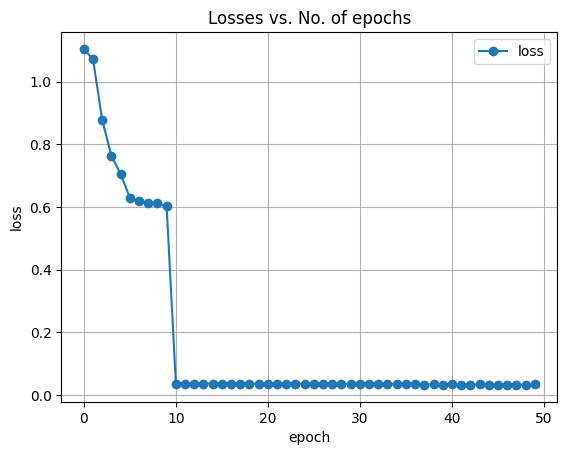

<Figure size 640x480 with 0 Axes>

In [8]:
from src.ConvAE.config import KEYS
from src.ConvAE.loss import BKGDLoss, BKMSELoss, SSIMLoss 

upload_your_own_parameters = False

if upload_your_own_parameters:
    optimal_parameters = np.load(os.path.join("preprocessed/heart", "optimal_parameters.npy"), allow_pickle=True).item()
else:
    optimal_parameters = {
        "BATCH_SIZE": 8,
        "DA": False,
        "in_channels": 4,
        "out_channels": 4,
        "latent_channels": 100,
        "activation": "leaky_relu",
        "optimizer": torch.optim.Adam,
        "lr": 2e-4,
        "weight_decay": 1e-5,
        "functions": {
            "BKGDLoss": BKGDLoss(), 
            "BKMSELoss": BKMSELoss()
            },
        "settling_epochs_BKGDLoss": 10,
        "settling_epochs_BKMSELoss": 0
        }
    np.save(os.path.join("preprocessed/heart", "optimal_parameters"), optimal_parameters)

assert optimal_parameters is not None, "Be sure to continue with a working set of hyperparameters"

BATCH_SIZE = optimal_parameters["BATCH_SIZE"]
DA = optimal_parameters["DA"]

ae = AE(**optimal_parameters, keys=KEYS).to(device)

ckpt = None
if ckpt is not None:
    ckpt = torch.load(ckpt)
    ae.load_state_dict(ckpt["AE"])
    ae.optimizer.load_state_dict(ckpt["AE_optim"])
    start = ckpt["epoch"]+1
else:
    start = 0

print(ae)

plot_history(
    ae.training_routine(
        range(start, 50),
        ACDCDataLoader("preprocessed/heart/training", patient_ids=train_ids, batch_size=BATCH_SIZE, transform=transform_augmentation if DA else transform),
        ACDCDataLoader("preprocessed/heart/training", patient_ids=val_ids, batch_size=BATCH_SIZE, transform=transform),
        "checkpoints/"
    )
)

## Testing

In [13]:
import os
import numpy as np
import torch
import nibabel as nib
from src.ConvAE.basic_model import AE
from src.utils.utilsAcdc import testing, display_image, display_difference, process_results, display_plots, ACDCDataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimal_parameters = np.load(os.path.join("preprocessed/heart", "optimal_parameters.npy"), allow_pickle=True).item()
assert optimal_parameters is not None, "Be sure to continue with a working set of hyperparameters"

ckpt = os.path.join("checkpoints", sorted([file for file in os.listdir("checkpoints") if "_best" in file])[-1])
ckpt = torch.load(ckpt)

ae = AE(**optimal_parameters, keys=KEYS).to(device)
ae.load_state_dict(ckpt["AE"])
ae.optimizer.load_state_dict(ckpt["AE_optim"])
ae.eval();

patient_info = np.load("preprocessed/heart/patient_info.npy", allow_pickle=True).item()
#spacings = [patient_info[id]["spacing"] for id in range(1, 101)]
#current_spacing = np.percentile(np.vstack(spacings), 50, 0)
current_spacing = [10, 1.25, 1.25]

test_loaders = {}
for model in os.listdir("preprocessed/heart/predictions/"):
    test_loaders[model] = ACDCDataLoader("preprocessed/heart/predictions/{}".format(model), patient_ids=range(101, 151), batch_size=BATCH_SIZE, transform=transform)

if not os.path.exists("postprocessed/heart/measures"):
    os.makedirs("postprocessed/heart/measures")
for model in sorted(test_loaders.keys()):
    if not os.path.exists("postprocessed/heart/predictions/{}".format(model)):
        os.makedirs("postprocessed/heart/predictions/{}".format(model))
    results = testing(ae, test_loaders[model], patient_info, "data/heart/predictions/{}".format(model), "postprocessed/heart/predictions/{}".format(model), current_spacing)
    np.save("postprocessed/heart/measures/{}_AE.npy".format(model), results)

data shape : (20, 336, 304)
slice_id = 0
data shape : (20, 336, 304)
slice_id = 1
data shape : (20, 336, 304)
slice_id = 2
data shape : (20, 336, 304)
slice_id = 3
data shape : (20, 336, 304)
slice_id = 4
data shape : (20, 336, 304)
slice_id = 5
data shape : (20, 336, 304)
slice_id = 6
data shape : (20, 336, 304)
slice_id = 7
data shape : (20, 336, 304)
slice_id = 8
data shape : (20, 336, 304)
slice_id = 9
data shape : (20, 336, 304)
slice_id = 10
data shape : (20, 336, 304)
slice_id = 11
data shape : (20, 336, 304)
slice_id = 12
data shape : (20, 336, 304)
slice_id = 13
data shape : (20, 336, 304)
slice_id = 14
data shape : (20, 336, 304)
slice_id = 15
data shape : (20, 336, 304)
slice_id = 16
data shape : (20, 336, 304)
slice_id = 17
data shape : (20, 336, 304)
slice_id = 18
data shape : (20, 336, 304)
slice_id = 19
data shape : (16, 320, 270)
slice_id = 0
data shape : (16, 320, 270)
slice_id = 1
data shape : (16, 320, 270)
slice_id = 2
data shape : (16, 320, 270)
slice_id = 3
data s

### Single Patient

In [27]:
model = "Bai"
patient_id = np.random.choice(range(101, 151))
phase = "ED"

prediction = nib.load("data/heart/predictions/{}/patient{:03d}_{}.nii.gz".format(model, patient_id, phase)).get_fdata().transpose(2, 1, 0)
reconstruction = nib.load("postprocessed/heart/predictions/{}/patient{:03d}_{}.nii.gz".format(model, patient_id, phase)).get_fdata().transpose(2, 1, 0)


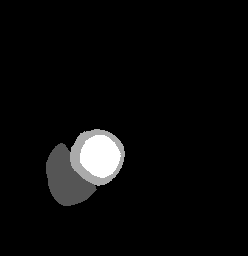

In [28]:
from src.utils.utilsAcdc import display_image, display_difference
display_image(prediction[2])

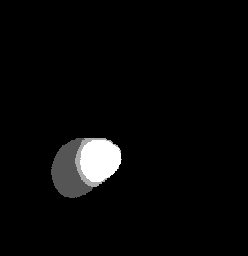

In [29]:
display_image(reconstruction[2])

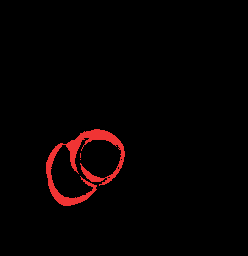

In [30]:
display_difference(prediction[2], reconstruction[2])